# Informatio Gain Feature Selection

####  friedman_aligned_ranks_test for the methods

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st
import itertools as it

def friedman_aligned_ranks_test(*args):
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    aligned_observations = []
    for i in range(n):
        loc = sp.mean([col[i] for col in args])
        aligned_observations.extend([col[i] - loc for col in args])
        
    aligned_observations_sort = sorted(aligned_observations)
    
    aligned_ranks = []
    for i in range(n):
        row = []
        for j in range(k):
            v = aligned_observations[i*k+j]
            row.append(aligned_observations_sort.index(v) + 1 + (aligned_observations_sort.count(v)-1)/2.)
        aligned_ranks.append(row)

    rankings_avg = [sp.mean([case[j] for case in aligned_ranks]) for j in range(k)]
    rankings_cmp = [r/sp.sqrt(k*(n*k+1)/6.) for r in rankings_avg]

    r_i = [np.sum(case) for case in aligned_ranks]
    r_j = [np.sum([case[j] for case in aligned_ranks]) for j in range(k)]
    T = (k-1) * (sp.sum(v**2 for v in r_j) - (k*n**2/4.) * (k*n+1)**2) / float(((k*n*(k*n+1)*(2*k*n+1))/6.) - (1./float(k))*sp.sum(v**2 for v in r_i))

    p_value = 1 - st.chi2.cdf(T, k-1)

    return T, p_value, rankings_avg, rankings_cmp

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
warnings.warn('my warning')
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns
from pylab import rcParams

In [4]:
import xgboost

xgboost.__version__

'0.81'

In [5]:
import time
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [6]:
ps_data=pd.read_csv('F:/Ministry ICERT/Phishing_Legitimate/phishing_new_sorted.csv')
ps_data.head(5)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,2,1,0,25,0,0,0,0,0,...,0,0,0,2,2,0,2,1,2,0
1,2,2,1,0,24,0,0,0,0,0,...,1,0,0,2,2,0,2,1,2,0
2,3,2,1,0,21,0,0,0,0,0,...,0,0,0,2,2,2,2,1,2,0
3,4,2,1,0,22,0,0,0,0,0,...,1,0,0,2,2,0,2,1,2,0
4,5,2,1,0,25,0,0,0,0,0,...,0,0,0,2,2,0,1,0,2,0


In [7]:
X=ps_data.iloc[:,1:49]
y=ps_data['CLASS_LABEL']
X.tail(5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.feature_selection import mutual_info_classif

In [10]:
from sklearn.ensemble import RandomForestClassifier
features = {}
type(features)

dict

In [11]:
feat_labels=ps_data.columns[1:]
forest= RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=-1)
forest.fit(X_train,y_train)
importance= forest.feature_importances_
indices= np.argsort(importance)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importance[indices[f]]))

 1) PctExtHyperlinks               0.165124
 2) PctExtNullSelfRedirectHyperlinksRT 0.123068
 3) NumDash                        0.081868
 4) UrlLength                      0.078406
 5) FrequentDomainNameMismatch     0.056003
 6) PathLength                     0.054995
 7) PctExtResourceUrls             0.053035
 8) PathLevel                      0.050173
 9) NumNumericChars                0.038775
10) PctNullSelfRedirectHyperlinks  0.033957
11) InsecureForms                  0.026947
12) ExtMetaScriptLinkRT            0.024849
13) SubmitInfoToEmail              0.020288
14) NumDots                        0.017159
15) HostnameLength                 0.016074
16) UrlLengthRT                    0.015852
17) NumQueryComponents             0.015300
18) QueryLength                    0.014593
19) NumUnderscore                  0.013531
20) PctExtResourceUrlsRT           0.010576
21) NumAmpersand                   0.010471
22) IframeOrFrame                  0.007800
23) SubdomainLevel          

In [12]:
ps_data.shape
feat=feat_labels[indices]
# print(feat)
# print(importance)
features = dict(zip(feat, importance))
# print(features)
featu=[]
for i, j in enumerate(features):
#     print(j)
    featu.append(j)
print(featu)
del featu[26:]
print(featu)

['PctExtHyperlinks', 'PctExtNullSelfRedirectHyperlinksRT', 'NumDash', 'UrlLength', 'FrequentDomainNameMismatch', 'PathLength', 'PctExtResourceUrls', 'PathLevel', 'NumNumericChars', 'PctNullSelfRedirectHyperlinks', 'InsecureForms', 'ExtMetaScriptLinkRT', 'SubmitInfoToEmail', 'NumDots', 'HostnameLength', 'UrlLengthRT', 'NumQueryComponents', 'QueryLength', 'NumUnderscore', 'PctExtResourceUrlsRT', 'NumAmpersand', 'IframeOrFrame', 'SubdomainLevel', 'NumSensitiveWords', 'ExtFavicon', 'DomainInPaths', 'NumDashInHostname', 'RandomString', 'AbnormalExtFormActionR', 'RelativeFormAction', 'NumPercent', 'EmbeddedBrandName', 'AbnormalFormAction', 'NoHttps', 'IpAddress', 'MissingTitle', 'ExtFormAction', 'ImagesOnlyInForm', 'SubdomainLevelRT', 'FakeLinkInStatusBar', 'DomainInSubdomains', 'RightClickDisabled', 'NumHash', 'AtSymbol', 'DoubleSlashInPath', 'TildeSymbol', 'PopUpWindow', 'HttpsInHostname']
['PctExtHyperlinks', 'PctExtNullSelfRedirectHyperlinksRT', 'NumDash', 'UrlLength', 'FrequentDomainNam

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

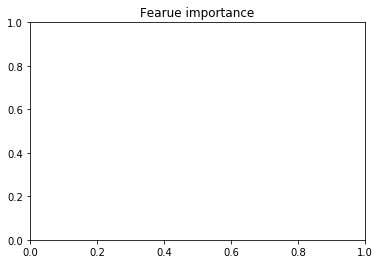

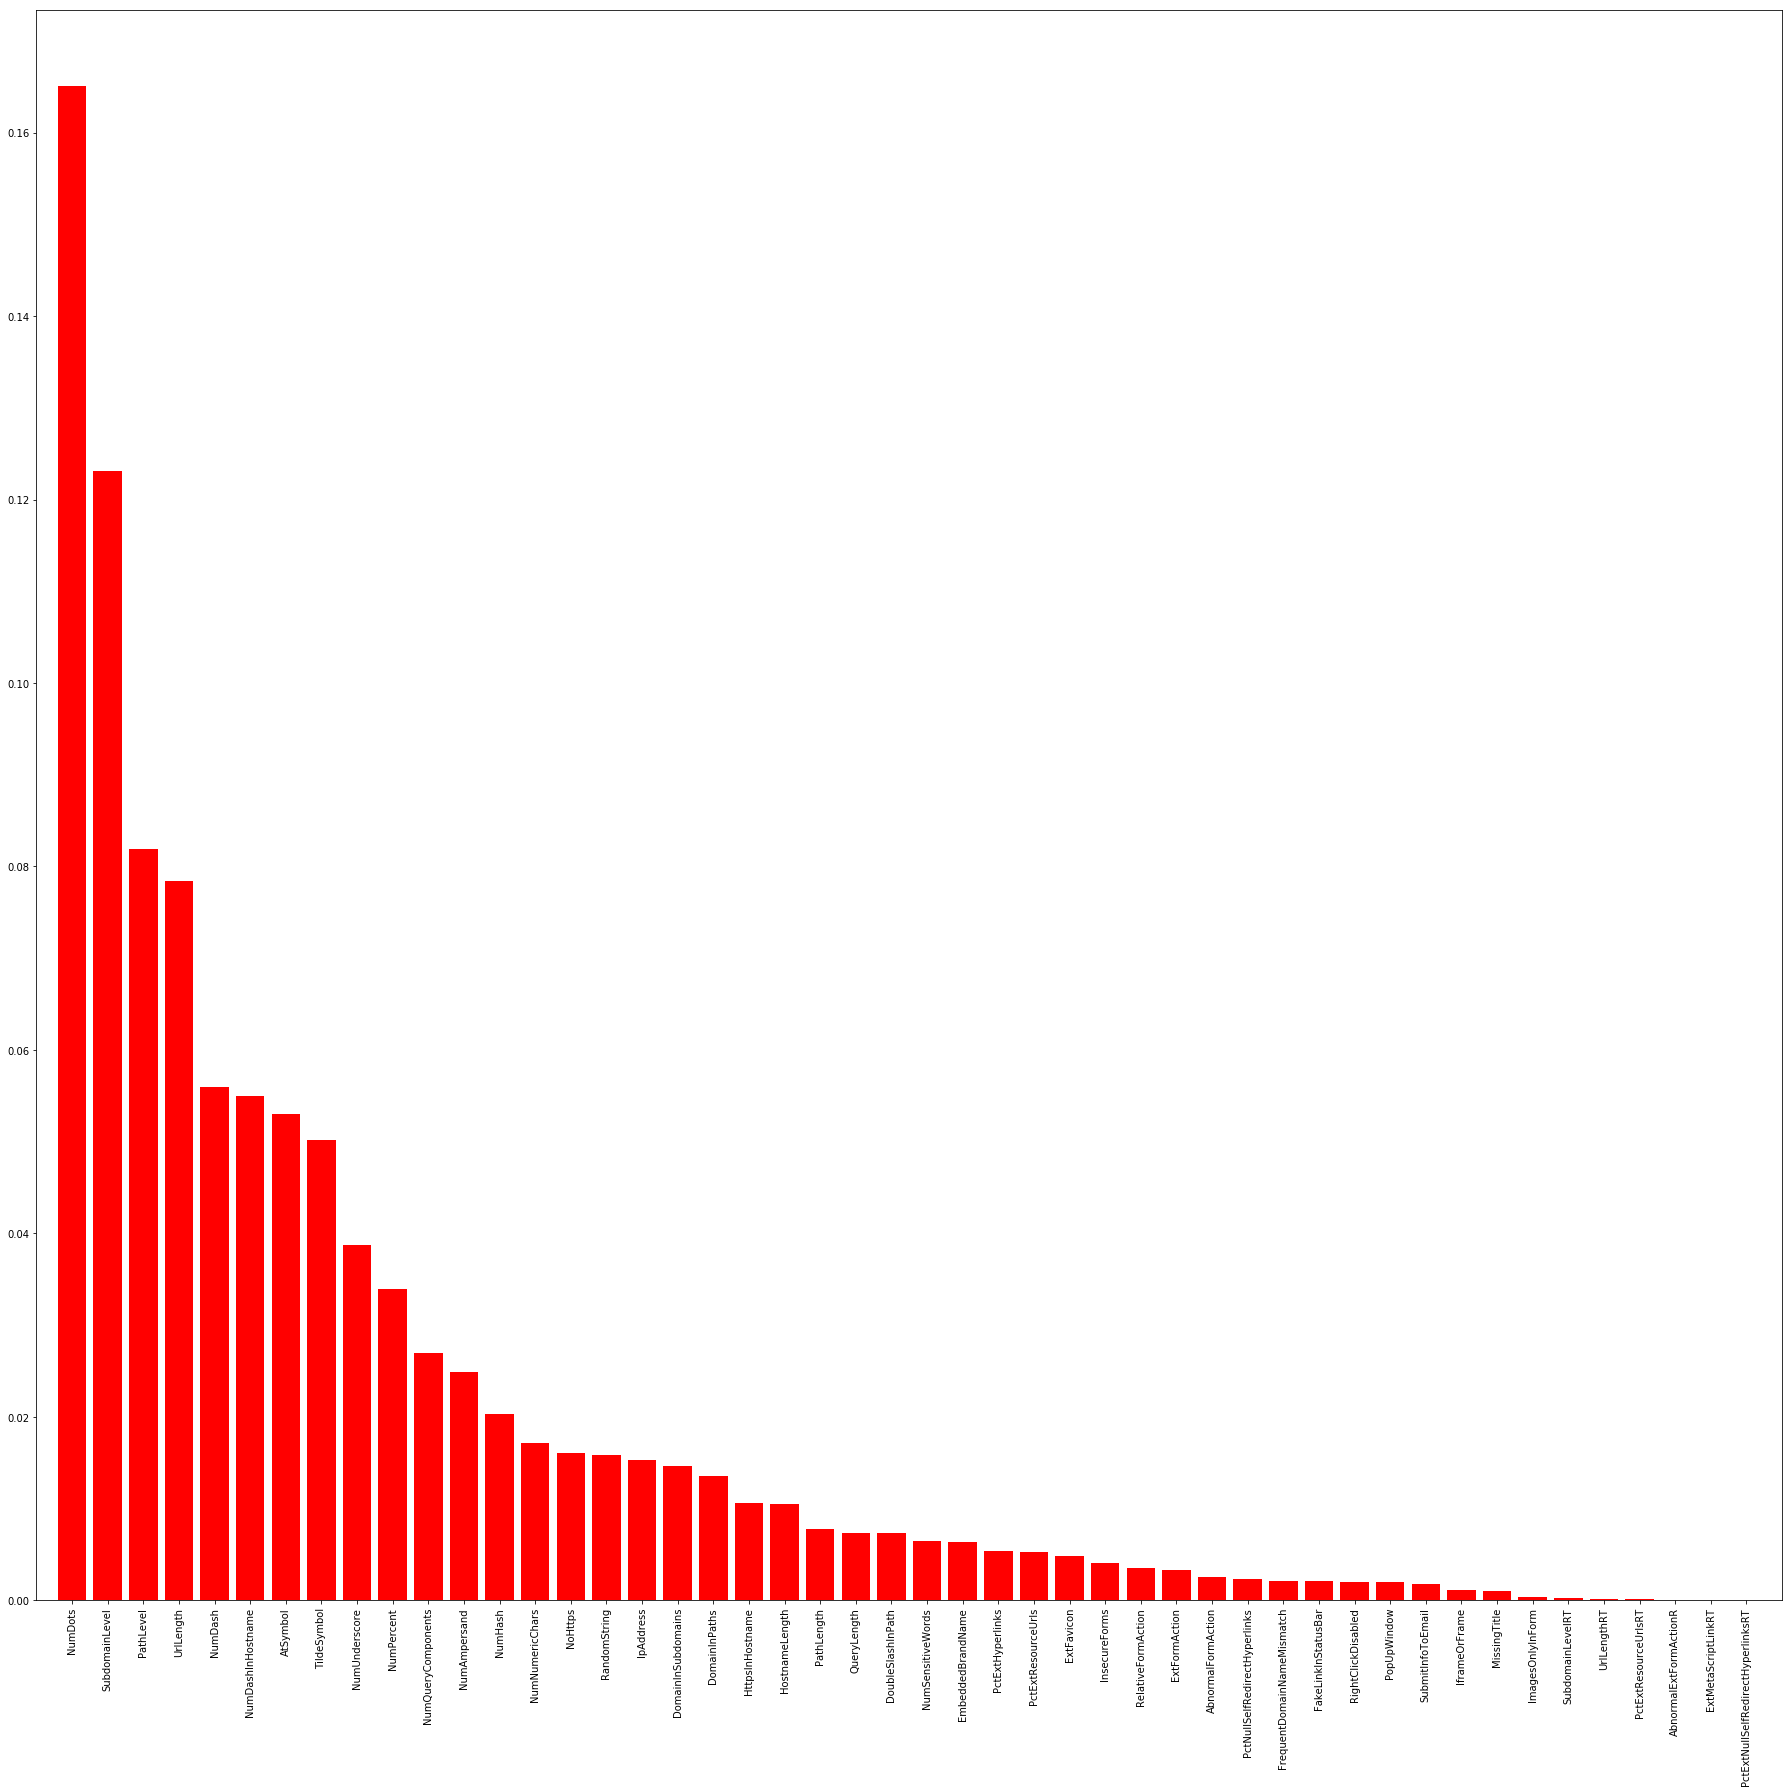

In [14]:
plt.title('Fearue importance')
plt.figure(figsize=(25,25))
plt.bar(range(X_train.shape[1]),importance[indices],color="red",align="center")
plt.xticks(range(X_train.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
# plt.show()

In [15]:
X =ps_data[featu]
print(X.shape)
X.tail(5)

(1000, 26)


,PctExtHyperlinks,PctExtNullSelfRedirectHyperlinksRT,NumDash,UrlLength,FrequentDomainNameMismatch,PathLength,PctExtResourceUrls,PathLevel,NumNumericChars,PctNullSelfRedirectHyperlinks,...,NumQueryComponents,QueryLength,NumUnderscore,PctExtResourceUrlsRT,NumAmpersand,IframeOrFrame,SubdomainLevel,NumSensitiveWords,ExtFavicon,DomainInPaths
995,1.000000,0,1,73,1,53,1.000000,4,18,0.000000,...,0,0,0,0,0,1,0,0,0,0
996,0.000000,0,0,44,1,14,0.785714,2,0,1.000000,...,0,0,0,0,0,1,1,0,0,1
997,0.000000,2,1,48,0,20,0.200000,2,0,0.058824,...,0,0,0,2,0,1,1,0,1,0
998,0.923077,0,0,25,1,6,1.000000,2,0,0.000000,...,0,0,0,2,0,0,0,0,0,0
999,0.000000,0,0,55,1,25,0.785714,4,0,1.000000,...,0,0,0,0,0,1,0,0,0,0


In [16]:
y=ps_data['CLASS_LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train.shape

(700,)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [18]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators =100,random_state=11)
import xgboost
from xgboost import XGBClassifier
xg=XGBClassifier(random_state=11)
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha =0.2)
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
rfc = RandomForestClassifier(n_estimators=100,random_state=11)
from sklearn import tree
clf =  tree.DecisionTreeClassifier()

In [19]:
  #defining a dictionary of classifier

classifier={'MultinomialNB': mnb,'GaussianNB': gnb,'logistic': lr,'RandomForest': rfc,'Adaboost': abc,\
        'XGBoost':xg,'KNeighbors':knn,'SVM':svc,'DecisionTreeClassifier':clf }

classifie=sorted(classifier.keys())
print(classifie)
df=pd.DataFrame(classifie,columns=['Classiifier'])
df

['Adaboost', 'DecisionTreeClassifier', 'GaussianNB', 'KNeighbors', 'MultinomialNB', 'RandomForest', 'SVM', 'XGBoost', 'logistic']


,Classiifier
0,Adaboost
1,DecisionTreeClassifier
2,GaussianNB
3,KNeighbors
4,MultinomialNB
5,RandomForest
6,SVM
7,XGBoost
8,logistic


<Figure size 2160x1800 with 0 Axes>

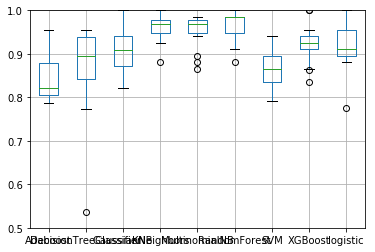

,Adaboost,DecisionTreeClassifier,GaussianNB,KNeighbors,MultinomialNB,RandomForest,SVM,XGBoost,logistic
0,0.000000,0.537313,0.940299,0.970149,0.880597,0.910448,0.940299,0.940299,0.776119
1,0.373134,0.820896,0.940299,0.985075,0.985075,1.000000,0.835821,0.910448,0.970149
2,0.820896,0.865672,0.820896,0.925373,0.955224,0.955224,0.865672,0.835821,0.880597
3,0.791045,0.955224,0.895522,0.940299,0.940299,0.940299,0.895522,0.910448,0.910448
4,0.820896,0.955224,0.925373,0.985075,0.970149,0.985075,0.850746,0.925373,0.925373
5,0.910448,0.955224,0.940299,0.970149,0.955224,0.970149,0.895522,0.925373,0.955224
6,0.820896,0.895522,0.835821,0.880597,0.865672,0.880597,0.791045,0.865672,0.880597
7,0.820896,0.940299,0.940299,0.955224,0.985075,0.985075,0.835821,0.940299,0.940299
8,0.820896,0.925373,0.895522,0.970149,0.895522,0.970149,0.820896,0.910448,0.970149
9,0.835821,0.880597,0.850746,0.955224,0.985075,0.985075,0.895522,0.910448,0.895522


In [20]:
#predict and storing score of each classifier
parameter = []
res=[]
plt.figure(figsize=(30,25))
fig, ax = plt.subplots()
res=pd.DataFrame(res)
for n,c in classifier.items():
    kfold = KFold(n_splits=15, random_state=0)
    results = cross_val_score(c, X, y, cv=kfold)
#     print("\n classifier",c,"\n Cross validation results \n",results)
    parameter.append((n,[np.mean(results)]))
#     testres=friedman_aligned_ranks_test(results)
    result=pd.DataFrame(results)
#     print(result)
    res=pd.concat([res,result],axis=1,ignore_index=True)
#     plt.ylabel('Accuracy')
#     plt.xticks(parameter_df['mean'])
# print(res)
res.columns = ['Adaboost','DecisionTreeClassifier','GaussianNB','KNeighbors','MultinomialNB','RandomForest','SVM',
          'XGBoost','logistic']

boxplot = res.boxplot(grid=True,figsize=(25,15))
boxplot.set_ylim([0.5,1.0])
plt.show()
res

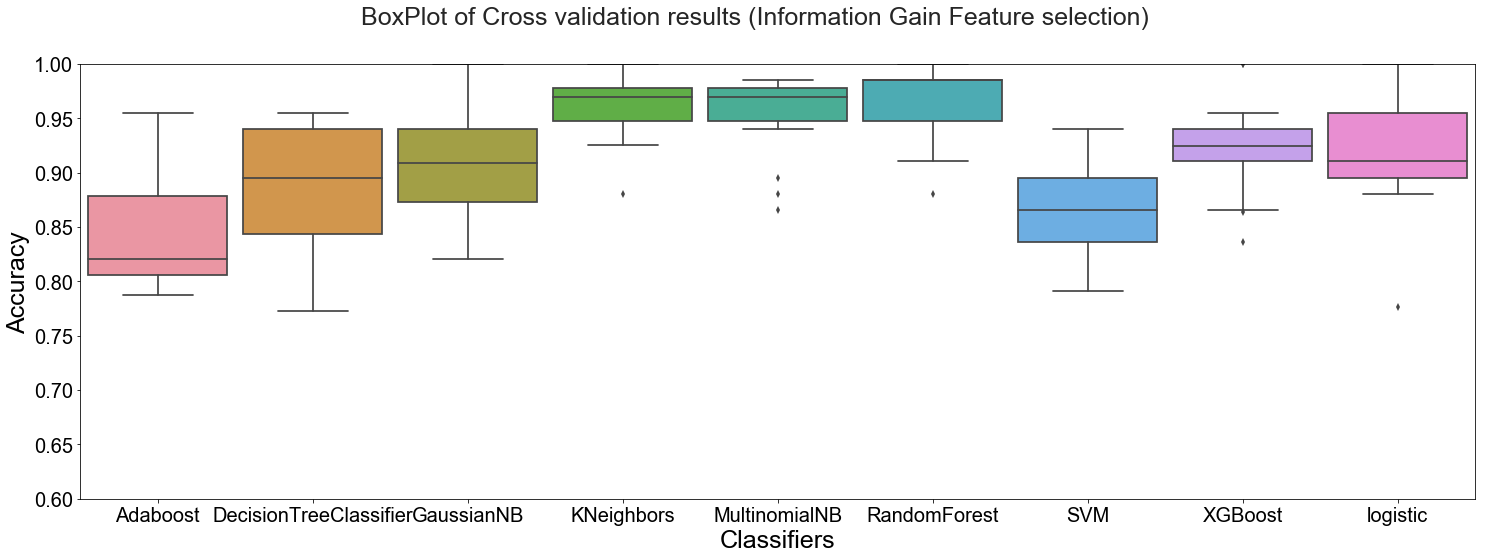

In [21]:
# rcParams['figure.figsize'] = 25,7
fig, ax = plt.subplots(figsize=(25,8))
sns.set(style="whitegrid")
boxplot=sns.boxplot(data=res,width=0.9)
boxplot.set_ylim([0.6,1.0])
fig.suptitle('BoxPlot of Cross validation results (Information Gain Feature selection)', fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Classifiers',fontsize=25)
plt.tick_params(axis='both', which='major', colors='black', labelsize=20)
plt.savefig('C:/Users/hp/Practice_Code/Feature_on_Phishing_Data_Code/Plotted_graph/IGgraph2.png')
plt.show()

In [22]:
p=friedman_aligned_ranks_test( res['Adaboost'],res['DecisionTreeClassifier'],res['GaussianNB'],res['KNeighbors'],
                              res['MultinomialNB'],res['RandomForest'],res['SVM'],res['XGBoost'],res['logistic'])
print(p)

# Chi2-value : float The computed Chi2-value of the test.
# p-value : float The associated p-value from the Chi2-distribution.
# rankings : array_like The ranking for each group.
# pivots : array_like The pivotal quantities for each group.

(69.53777959534486, 6.073808123119306e-12, [19.533333333333335, 50.266666666666666, 60.63333333333333, 101.36666666666666, 97.1, 108.33333333333333, 34.56666666666667, 70.23333333333333, 69.96666666666667], [1.3676068820673564, 3.5193706111903977, 4.245182454744916, 7.097086225881962, 6.798359807955987, 7.584850455151719, 2.4201507452284106, 4.917316895078361, 4.898646493957988])


In [25]:
parameter_df=pd.DataFrame.from_items(parameter,orient='index',columns=['mean'])
parameter_df

,mean
MultinomialNB,0.762611
GaussianNB,0.869968
logistic,0.909106
RandomForest,0.960063
Adaboost,0.951093
XGBoost,0.966079
KNeighbors,0.866033
SVM,0.921137
DecisionTreeClassifier,0.918076


In [26]:
def training(clf,X_train,y_train):
    clf.fit(X_train,y_train)
    
def predict(clf,X_test):
    return clf.predict(X_test)


 Classifier is: 
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=11)
 Total time in : 
 0.5007121562957764
Confusion_matrix 
 [[145   5]
 [  5 145]]
0.9666666666666667
0.9666666666666667
AUC: 0.967

 Classifier is: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
 Total time in : 
 0.007994651794433594
Confusion_matrix 
 [[142   8]
 [ 13 137]]
0.9448275862068966
0.9133333333333333
AUC: 0.930

 Classifier is: 
 GaussianNB(priors=None, var_smoothing=1e-09)
 Total time in : 
 0.0039980411529541016
Confusion_matrix 
 [[136  14]
 [ 19 131]]
0.903448275862069
0.8733333333333333
AUC: 0.890

 Classifier is: 
 KNeighborsCla

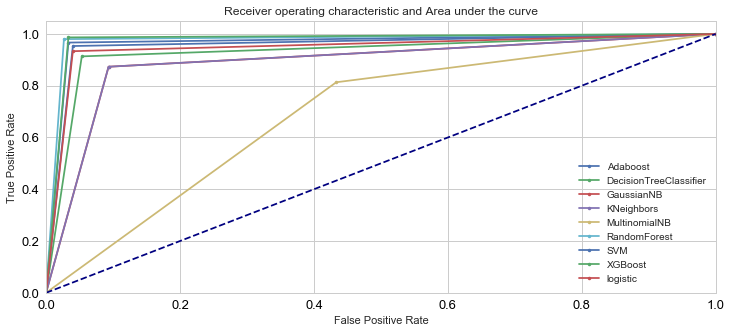

In [27]:
score = []
plt.subplots(figsize=(12,5))
for n,c in sorted(classifier.items()):
    start = time.time()
    c.fit(X_train,y_train)
    pred = predict(c,X_test)
    end = time.time()
    print("\n Classifier is: \n",c)
    print(" Total time in : \n",end - start)
#     print("",c)
    score.append((n,[accuracy_score(y_test,pred,normalize=True),metrics.precision_score(y_test, pred),
                    metrics.recall_score(y_test, pred)]))
    print("Confusion_matrix \n",confusion_matrix(y_test,pred))
    precision=metrics.precision_score(y_test, pred)
    print(precision)
    recall=metrics.recall_score(y_test, pred)
    print(recall)
#     ROC AND AUC CURVE
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    # calculate AUC
    auc = roc_auc_score(y_test, pred)
    print('AUC: %.3f' % auc)
    plt.plot(fpr, tpr,marker='.',label=n)
    # plot no skill
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    # plot the roc curve for the model

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic and Area under the curve', fontsize=12)
plt.legend(loc=0,fontsize='small')
plt.tick_params(axis='both', which='major', colors='black', labelsize=13)
plt.savefig('C:/Users/hp/Practice_Code/Feature_on_Phishing_Data_Code/Plotted_graph/IGgraph3.png')
    # show the plot
plt.show()

In [28]:
score_df=pd.DataFrame.from_items(score,orient='index',columns=['scores','Precision','Recall'])
#Adding accuracy column
score_df['Accuracy (%)']=score_df['scores']*100
score_df

,scores,Precision,Recall,Accuracy (%)
Adaboost,0.966667,0.966667,0.966667,96.666667
DecisionTreeClassifier,0.930000,0.944828,0.913333,93.000000
GaussianNB,0.890000,0.903448,0.873333,89.000000
KNeighbors,0.890000,0.903448,0.873333,89.000000
MultinomialNB,0.690000,0.652406,0.813333,69.000000
RandomForest,0.976667,0.973510,0.980000,97.666667
SVM,0.956667,0.959732,0.953333,95.666667
XGBoost,0.976667,0.967320,0.986667,97.666667
logistic,0.946667,0.958904,0.933333,94.666667


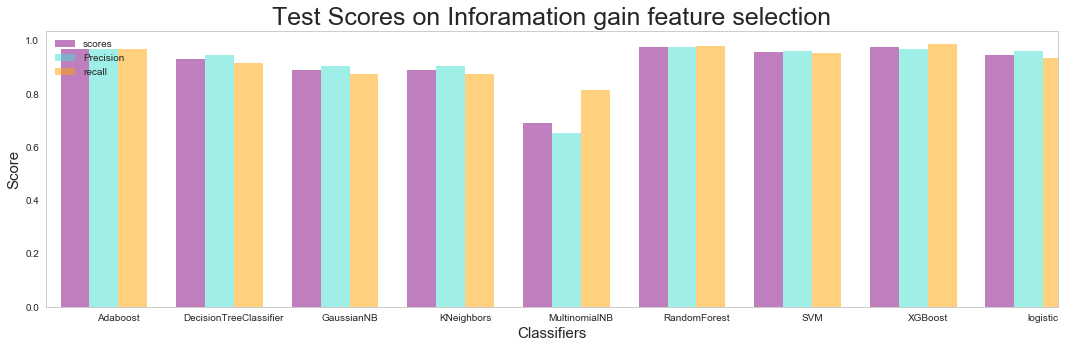

In [30]:
pos = list(range(len(df['Classiifier']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,5)) 
# Create a bar with pre_score data,in position pos,
plt.bar(pos,score_df['scores'],width,alpha=0.5,color='purple',label=score_df['scores'][0]) 
plt.bar([p + width for p in pos],score_df['Precision'],width,alpha=0.5,color='turquoise',label=score_df['Precision'][1]) 
plt.bar([p + width*2 for p in pos],score_df['Recall'],width,alpha=0.5, color='orange',label=score_df['Recall']) 

ax.set_ylabel('Score',fontsize=15)
ax.set_xlabel('Classifiers',fontsize=15)
ax.set_title('Test Scores on Inforamation gain feature selection',fontsize=25)
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df['Classiifier'])
plt.xlim(min(pos)-width, max(pos)+width*2)
# plt.ylim([0, max(score_df['scores'] + score_df['Precision'] + score_df['Recall'])] )
# plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.legend(['scores', 'Precision', 'recall'], loc='upper left')
plt.grid()
plt.savefig('C:/Users/hp/Practice_Code/Feature_on_Phishing_Data_Code/Plotted_graph/IGgraph1.png')
plt.show()